# Recovery of gold from ore

Preparation of a model for predicting the recovery factor of gold from gold-bearing ore using data with mining and refining parameters to optimize production.

Stages:
- Preparing data for correct work with them (changing data type, getting rid of anomalies and omissions);
- exploratory data analysis;
- Building and training several models to further predict the recovery factor of gold from gold ore and select the best one for further use, minimizing the final sMAPE metric.

## Data preparation

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [2]:
df_train = pd.read_csv('gold_recovery_train_new.csv')
df_test = pd.read_csv('gold_recovery_test_new.csv')
df_full = pd.read_csv('gold_recovery_full_new.csv')

In [3]:
df_test.head() 

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [4]:
df_train.shape

(14149, 87)

In [5]:
df_train.shape[0] / df_full.shape[0]

0.7278666598076032

In [6]:
df_test.shape[0] / df_full.shape[0]

0.2721333401923967

In [7]:
df_test.shape

(5290, 53)

In [8]:
df_full.shape

(19439, 87)

In [9]:
df_train.shape[0] + df_test.shape[0] - df_full.shape[0]

0

In [10]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
date                                                  19439 non-null object
final.output.concentrate_ag                           19438 non-null float64
final.output.concentrate_pb                           19438 non-null float64
final.output.concentrate_sol                          19228 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19438 non-null float64
final.output.tail_pb                                  19338 non-null float64
final.output.tail_sol                                 19433 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19415 non-null float64
primary_cleaner.input.depressant             

### Comments
In the presented datasets, there are gaps in most features. The date feature, unlike other features with float data types, is of the object type.

In [11]:
NAME_C = 'rougher.output.concentrate_au'
NAME_F = 'rougher.input.feed_au'
NAME_T = 'rougher.output.tail_au'

In [12]:
train_conc = pd.DataFrame([])
train_conc['rougher.output.recovery'] = df_train['rougher.output.recovery']

In [13]:
train_conc['rougher.output.recovery_cal'] = (df_train[NAME_C] * (df_train[NAME_F] - 
                                                               df_train[NAME_T] )) * 100 / (df_train[NAME_F] * (df_train[NAME_C] - df_train[NAME_T] )) 

In [14]:
train_conc[['rougher.output.recovery_cal','rougher.output.recovery']].head()

,rougher.output.recovery_cal,rougher.output.recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [15]:
mae_au = mean_absolute_error(train_conc['rougher.output.recovery'], train_conc['rougher.output.recovery_cal'])
print(mae_au)

1.1100347049376097e-14


### Comments
The correctness of the enrichment efficiency calculation on the training set for the feature rougher.output.recovery was checked. When visually comparing the first five objects, no differences were noticed. MAE between the calculations and the value of the sign was 1%, which confirms the correctness of the preliminary calculation.


In [16]:
train_cols = df_train.columns
test_cols = df_test.columns
train_not_test = train_cols.difference(test_cols)

In [17]:
train_not_test

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

In [18]:
test_cols

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

In [19]:
rougher_cols = []
for el in  test_cols:
    b = el.split('.')
    if 'rougher' in b:
        rougher_cols.append(el)

### Comments

In the test sample, 35 features related to all stages of the technological process turned out to be inaccessible. Most of the missing features relate to the parameters of the product, and some of the calculated characteristics at the flotation stage are also missing: target features, features associated with the concentration calculation. Presumably, the features present in the test set are necessary for training the model to predict the efficiency of the enrichment of the final concentrate. For another target trait from the same list, only related to rougher.

In [20]:
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')

In [21]:
df_full = df_full.fillna(method="ffill")
df_train = df_train.fillna(method="ffill")
df_test = df_test.fillna(method="ffill")

In [22]:
df_test_1 = pd.merge(df_test,df_full, how='inner')
display(df_test_1.shape)

(5290, 87)

### Comments

In the process of data preprocessing, the data type of the 'date' attribute was converted from object to datetime in all samples. After that, gaps were filled in relative to the previous value in time in all samples.

## Data analysis

In [23]:
def plot_conc(data1, data2):
    mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']
    column = data2.columns
    x = data1
    y1 = data2[column[0]]
    y2 = data2[column[1]]
    y3 = data2[column[2]]
    name_t = ('Concentrate',column[0].split('_')[1].upper())
    name_t_1 = ' '.join(map(str, name_t))
    y1.hist(bins=50 ,figsize = (10,7), alpha = 0.6, grid = True)
    y2.hist(bins=50, alpha = 0.6)
    y3.hist(bins=50, alpha = 0.6)
    plt.title(name_t_1, fontsize=16)
    plt.xlabel('Concentrate, %')
    plt.ylabel('Count')
    plt.legend(column)
    plt.show()
    


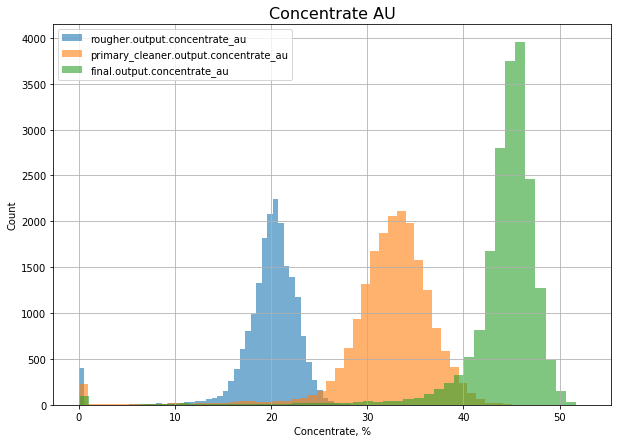

In [24]:
plot_conc(df_full['date'], df_full[['rougher.output.concentrate_au',
                                    'primary_cleaner.output.concentrate_au','final.output.concentrate_au']]) 
          

The histogram shows that the concentration of gold gradually increases at each subsequent processing stage: from 21% after flotation to 47% at the final stage. Zero values ​​of gold concentration are also observed, and at the flotation stage, such values are the most.
Possible reasons for close to zero concentration values:
- there was a low content of the desired metal in the ore;

- measurement accuracy does not allow to determine the low content and therefore the values are considered zero;

- there is an installation (process) error that leaves the metal in the tailings;
- failures of measuring sensors or planned shutdown of measuring equipment for some reason (cleaning, replacement, etc.).


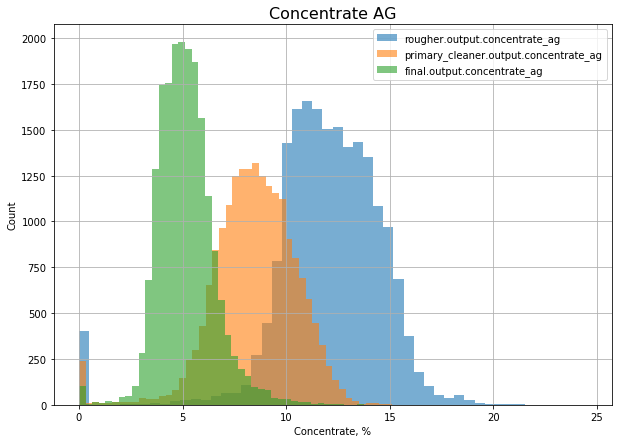

In [25]:
plot_conc(df_full['date'], df_full[['rougher.output.concentrate_ag',
                                    'primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']])

As for the silver concentration, it gradually decreases at each subsequent processing stage: from 12% after flotation to 5% at the final stage. Zero concentrations of silver are also observed, as well as gold.  


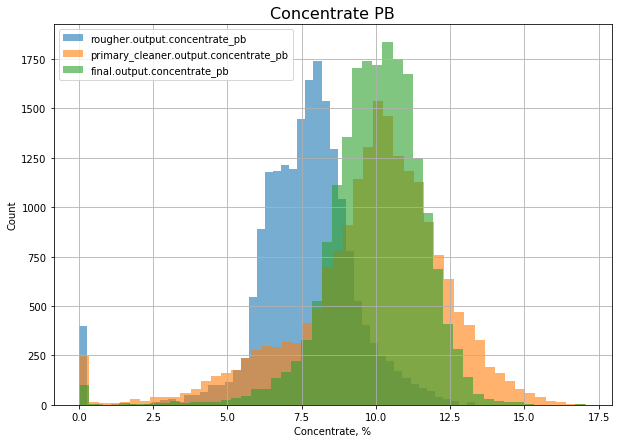

In [26]:
plot_conc(df_full['date'], df_full[['rougher.output.concentrate_pb',
                                    'primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']])

The concentration of tin increases after the primary treatment compared to the flotation stage, and this amount is maintained in the final stage with some small scatter in values.


### Comments

From the presented graphs, it can be seen that:
 - the concentration of gold gradually increases by about 2 times: from 21% after flotation to 47% at the final stage;
 - silver concentration gradually decreases from 12% after flotation to 5% at the final stage;
 - the concentration of tin increases slightly after the first cleaning and remains after the second cleaning: from 8% after flotation to 11% at the final stage. It can also be noted that over time, the tin recovery began to improve, since after the first stonecrop the concentration increased compared to the flotation stage, but this was not observed in the earlier observation period.
 
 Zero values of metal concentration are also observed, for example, at the flotation stage there are more such values ​​than at other stages.

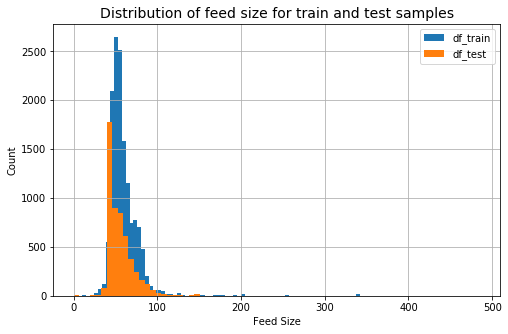

In [27]:
df_train['rougher.input.feed_size'].hist(bins = 100, figsize = (8,5), grid = True)
df_test_1['rougher.input.feed_size'].hist(bins = 60)
plt.title('Distribution of feed size for train and test samples', fontsize=14)
plt.xlabel('Feed Size')
plt.ylabel('Count')
plt.legend(['df_train','df_test'])
plt.show()

In [28]:
df_test_1['rougher.input.feed_size'].apply(['median','mean'])

median    50.846843
mean      55.952754
Name: rougher.input.feed_size, dtype: float64

In [29]:
df_train['rougher.input.feed_size'].apply(['median','mean'])

median    55.269784
mean      60.239856
Name: rougher.input.feed_size, dtype: float64

### Comments

Calculations of the average value and median value of the raw material granule size in the training and test samples differ by no more than 10%.

In [30]:
name_1 =['final.output.concentrate_ag','final.output.concentrate_pb',
         'final.output.concentrate_sol','final.output.concentrate_au'] 
name_2 =['rougher.output.concentrate_ag','rougher.output.concentrate_pb',
         'rougher.output.concentrate_sol','rougher.output.concentrate_au']
name_3 =['rougher.input.feed_ag','rougher.input.feed_pb',
         'rougher.input.feed_sol','rougher.input.feed_au']

In [31]:
df_train['total_concentrate_final'] = df_train[name_1].sum(axis=1)
df_train['total_concentrate_feed'] = df_train[name_3].sum(axis=1)
df_train['total_concentrate_rougher'] = df_train[name_2].sum(axis=1)
df_test_1['total_concentrate_final'] = df_test_1[name_1].sum(axis=1)
df_test_1['total_concentrate_feed'] = df_test_1[name_3].sum(axis=1)
df_test_1['total_concentrate_rougher'] = df_test_1[name_2].sum(axis=1)

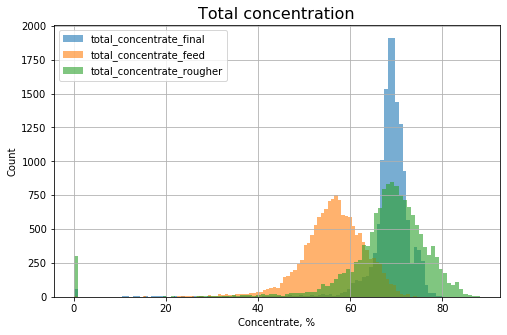

In [32]:
df_train['total_concentrate_final'].hist(bins = 100, figsize = (8,5), grid = True, alpha = 0.6)
df_train['total_concentrate_feed'].hist(bins = 100, alpha = 0.6)
df_train['total_concentrate_rougher'].hist(bins = 100, alpha = 0.6)
plt.title('Total concentration', fontsize=16)
plt.xlabel('Concentrate, %')
plt.ylabel('Count')
plt.legend(['total_concentrate_final','total_concentrate_feed','total_concentrate_rougher'])
plt.show()

On the distribution graph of the final concentration, one can observe zero values, and there are no such values for raw materials. The maximum value is observed for the crude concentrate. Therefore, it can be concluded that the detected values are anomalous.

In [33]:
df_test_1[['total_concentrate_final','total_concentrate_feed','total_concentrate_rougher']].describe()

,total_concentrate_final,total_concentrate_feed,total_concentrate_rougher
count,5290.000000,5290.000000,5290.000000
mean,69.364422,60.205741,70.839436
std,8.372254,6.896581,11.459427
min,0.000000,4.501868,0.000000
25%,69.342800,56.458730,69.237656
50%,70.688587,59.999831,72.691886
75%,72.073175,65.099348,75.826641
max,79.977670,76.978947,86.393020


In [34]:
df_train[['total_concentrate_final','total_concentrate_feed','total_concentrate_rougher']].describe()

,total_concentrate_final,total_concentrate_feed,total_concentrate_rougher
count,14149.000000,14149.000000,14149.000000
mean,68.387872,56.242170,67.173145
std,7.023723,7.029808,12.713129
min,0.000000,0.040000,0.000000
25%,67.559819,52.573579,64.914390
50%,69.141502,56.627635,69.175663
75%,70.974661,60.763234,73.429261
max,80.210644,74.458253,88.140119


In [35]:
df_test_1[df_test_1['total_concentrate_rougher'] == 0.0].head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,total_concentrate_final,total_concentrate_feed,total_concentrate_rougher
30,2016-09-02 06:59:59,126.329123,8.003034,7.160,0.699695,412.629243,-795.316337,413.703253,-787.396567,441.604260,...,0.165631,15.577148,3.107993,12.870691,5.463488,6.333927,5.552634,0.000000,4.501868,0.0
85,2016-09-04 17:59:59,141.260562,8.041141,7.940,0.593102,1302.984840,-499.988453,1297.834274,-500.210380,1295.561077,...,1.043818,18.038498,2.933052,12.891285,5.392984,9.401645,6.025343,70.867621,57.057235,0.0
86,2016-09-04 18:59:59,135.403245,8.109890,8.235,0.598479,1302.737427,-500.201316,1297.553194,-499.405170,1295.736073,...,0.944632,17.302978,2.706709,12.812069,5.285657,9.454770,6.057976,70.789293,49.714754,0.0
87,2016-09-04 19:59:59,134.214024,8.002202,8.530,0.625177,1303.125981,-499.867508,1297.296122,-500.401509,1296.123016,...,1.042972,16.871936,2.869191,12.730654,5.460283,9.089512,6.251781,70.650976,54.782762,0.0
88,2016-09-04 20:59:59,131.144955,8.052567,8.290,0.561138,1303.050322,-499.840711,1297.350695,-499.390859,1296.558438,...,0.942410,16.710651,2.581245,12.170171,5.541685,8.977682,6.349513,70.389223,55.174003,0.0


In [36]:
display((df_train['total_concentrate_rougher'] == 0.0).mean())
display((df_train['total_concentrate_feed'] == 0.0).mean())
display((df_train['total_concentrate_final'] == 0.0).mean())

0.02099088274789738

0.0

0.004099229627535515

In [37]:
display((df_test_1['total_concentrate_rougher'] == 0.0).mean())
display((df_test_1['total_concentrate_feed'] == 0.0).mean())
display((df_test_1['total_concentrate_final'] == 0.0).mean())

0.01833648393194707

0.0

0.007561436672967864

In [38]:
df_train_new = df_train[(df_train['total_concentrate_rougher'] > 0.5)  & (df_train['total_concentrate_final'] > 0.5)].copy()
df_test_new = df_test_1[(df_test_1['total_concentrate_rougher'] > 0.5)  & (df_test_1['total_concentrate_final'] > 0.5)].copy()

In [39]:
df_train_new.shape

(13789, 90)

In [40]:
df_test_new.shape

(5154, 90)

### Comments

When studying the total concentration of all substances at different stages (in raw materials, in roughing and final concentrates), zero values of metal concentrations were found. These anomalies are observed both in the training sample and in the test sample and make up no more than 3% of the entire sample. Therefore, all objects with anomalous values of the total concentration were removed.

## Model

In [41]:
def features_target_final(data):
    features_0 = data[test_cols]
    features_1 = features_0.drop(['date'] , axis=1)
    target_2 = data['final.output.recovery'] 
    return features_1, target_2

In [42]:
def features_target_rougher(data):
    features_0 = data[rougher_cols]
    target_1 = data['rougher.output.recovery'] 
    return features_0, target_1

In [43]:
def scal(data_1, data_2):
    scaler = StandardScaler()
    scaler.fit(data_1[data_2.columns])
    pd.options.mode.chained_assignment = None
    data_1[data_2.columns] = scaler.transform(data_1[data_2.columns])
    data_2[data_2.columns] = scaler.transform(data_2[data_2.columns])
    return data_1, data_2

In [44]:
features_train_r, target_train_r = features_target_rougher(df_train_new)
features_train_f, target_train_f = features_target_final(df_train_new)

In [45]:
features_test_r, target_test_r = features_target_rougher(df_test_new)
features_test_f, target_test_f = features_target_final(df_test_new)

In [46]:
features_train_r_s, features_test_r_s = scal(features_train_r, features_test_r)
features_train_f_s, features_test_f_s = scal(features_train_f, features_test_f)

In [47]:
def smape(target, prediction):
    smape_0 = sum(abs(target - prediction)  / ((abs(target) + abs(prediction)) / 2) ) * 100 / len(target)
    return smape_0

In [48]:
def final_smape(df_t_r, df_p_r, df_t_f, df_p_f):
    smape_r = smape(df_t_r, df_p_r)
    smape_f = smape(df_t_f, df_p_f)
    smape_res = .25 * smape_r + .75 * smape_f
    return smape_res

In [49]:
my_score = make_scorer(smape, greater_is_better=True)

In [50]:
def models(features, target, model_name, parameter):
    start_time = datetime.now()
    model = GridSearchCV(model_name, parameter, refit=True, scoring = my_score, cv=5)
    best_model = model.fit(features,target)
    prediction = best_model.predict(features)
    end_time = datetime.now()
    time = end_time - start_time
    print(best_model.best_params_)
    return best_model, prediction, best_model.best_params_, time

In [51]:
lr_r =  LinearRegression()
lr_f =  LinearRegression()
parameters = {'normalize':[True,False]}

In [52]:
features_train_r_s

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,-1.312926,-1.117774,0.467649,-0.206471,0.100750,-0.716451,0.088026,0.122796,0.134448,0.146462,...,1.537291,0.512470,1.415459,0.406969,1.844453,0.252348,1.703906,0.164776,2.159650,0.222883
1,-1.280668,-1.135122,0.484518,-0.128847,-0.113934,-0.720407,0.083271,0.120769,0.177387,0.151971,...,1.524894,0.246803,1.406522,0.270362,1.852064,0.276434,1.675804,0.246001,2.064813,0.255069
2,-1.304387,-1.232901,0.530321,-0.118798,-0.069531,-0.781238,0.067673,0.295406,0.156955,0.308127,...,1.517109,0.245842,1.402718,0.268144,1.848818,0.276424,1.675557,0.262487,2.068217,0.247854
3,-1.343238,-1.344834,0.651827,-0.106579,0.111664,-0.908813,-0.021898,0.300692,0.095583,0.301577,...,1.521075,0.235183,1.404321,0.268932,1.838653,0.273263,1.684999,0.260850,2.067750,0.260870
4,-1.333886,-1.575409,0.631919,-0.182189,-0.399929,-1.146408,-0.229195,0.296727,-0.101560,0.300210,...,1.521896,0.252971,1.405947,0.266713,1.848386,0.277222,1.688309,0.281239,2.073026,0.249975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,-1.317453,1.025642,0.828796,1.103038,0.214922,-1.317799,-1.214283,2.994306,-0.961794,2.708072,...,-0.952321,-0.604611,-1.198732,-0.599887,-1.277030,-0.607558,-1.268687,-0.608922,-1.070476,-0.581628
14145,-1.301802,0.591408,0.810834,2.566284,0.463494,-1.577748,-1.339488,3.127685,-1.142590,2.823421,...,-0.964037,-0.636316,-1.195893,-0.645022,-1.262039,-0.623202,-1.274847,-0.627931,-1.069022,-0.570552
14146,-1.381901,0.476561,0.778446,2.685985,0.765105,-1.741670,-1.577102,3.122813,-1.280328,2.825218,...,-0.951580,-0.655661,-1.190996,-0.638148,-1.248022,-0.665052,-1.272164,-0.631756,-1.066500,-0.748674
14147,-1.340677,0.368625,0.672535,2.750081,0.691838,-1.826507,-1.693001,3.121084,-1.381229,2.822828,...,-0.928810,-0.626348,-1.170223,-0.632564,-1.289004,-0.566492,-1.258374,-0.605845,-1.061426,-0.611219


In [53]:
%%time
best_model_lr_r, prediction_lr_r, params_lr_r, time_lr_r = models(features_train_r_s, target_train_r, lr_r, parameters)

{'normalize': True}
CPU times: user 1.21 s, sys: 1.24 s, total: 2.46 s
Wall time: 2.41 s


In [54]:
prediction_lr_r.shape

(13789,)

In [55]:
%%time
best_model_lr_f, prediction_lr_f, params_lr_f, time_lr_f = models(features_train_f_s, target_train_f, lr_f, parameters)

{'normalize': True}
CPU times: user 2.09 s, sys: 1.95 s, total: 4.04 s
Wall time: 4.08 s


In [56]:
time_lr = time_lr_r + time_lr_f

In [57]:
final_smape_lr = final_smape(target_train_r, prediction_lr_r, target_train_f, prediction_lr_f)

In [58]:
final_smape_lr

7.337853168609965

The first model considered is linear regression. Has a high learning rate. The GridSearchCV tool was chosen to select the best model with hyperparameter enumeration and cross-validation. Linear regression is a fairly self-sufficient model, so the minimum number of changeable hyperparameters is chosen for the fitting tool to work and this is 'normalize':[True,False].
    
As a result of enumeration of a small number of hyperparameters and cross-validation, consisting of 5 samples, the option was chosen: {'normalize': True}. The total total training time for the two models for rougher and final was less than 6 seconds. The final sMAPE metric is 7.34%.


In [59]:
dtr_r =  DecisionTreeRegressor()
dtr_f =  DecisionTreeRegressor()
parameters = {'max_depth': range(2,17,2)}

In [60]:
%%time
best_model_dtr_r, prediction_dtr_r, params_dtr_r, time_dtr_r = models(features_train_r_s, target_train_r, dtr_r, parameters)

{'max_depth': 16}
CPU times: user 9.16 s, sys: 0 ns, total: 9.16 s
Wall time: 9.21 s


In [61]:
%%time
best_model_dtr_f, prediction_dtr_f, params_dtr_f, time_dtr_f = models(features_train_f_s, target_train_f, dtr_f, parameters)

{'max_depth': 16}
CPU times: user 22 s, sys: 0 ns, total: 22 s
Wall time: 22.2 s


In [62]:
time_dtr = time_dtr_r + time_dtr_f

In [63]:
final_smape_dtr = final_smape(target_train_r, prediction_dtr_r, target_train_f, prediction_dtr_f)
display(round(final_smape_dtr,2))

2.35

The following model was trained based on a decision tree. One hyperparameter was chosen - the depth of the tree in the range from 2 to 16 with a step of 2. Due to the different number of features in the samples, different depth values were obtained to obtain the target rougher.output.recovery and final.output.recovery: 16 and 14, respectively. The total training time is less than 32 seconds. The final metric is 2.92%. Perhaps, by increasing the range of the tree depth, we could contribute to a decrease in the value of the metric, but this would increase the likelihood of retraining the model.


In [64]:
rfr_r =  RandomForestRegressor()
rfr_f =  RandomForestRegressor()
parameters = {'max_depth': [2,4,6,8,10], 'n_estimators': [5,10,20,30,40,50]}

In [65]:
%%time
best_model_rfr_r, prediction_rfr_r, params_rfr_r, time_rfr_r = models(features_train_r_s, target_train_r, rfr_r, parameters)

{'max_depth': 2, 'n_estimators': 5}
CPU times: user 6min 15s, sys: 135 ms, total: 6min 15s
Wall time: 6min 19s


In [66]:
%%time
best_model_rfr_f, prediction_rfr_f, params_rfr_f, time_rfr_f = models(features_train_f_s, target_train_f, rfr_f, parameters)

{'max_depth': 10, 'n_estimators': 5}
CPU times: user 14min 36s, sys: 490 ms, total: 14min 37s
Wall time: 14min 45s


In [67]:
time_rfr = time_rfr_r + time_rfr_f

In [68]:
final_smape_rfr = final_smape(target_train_r, prediction_rfr_r, target_train_f, prediction_rfr_f)
display(round(final_smape_rfr,2))

5.66

The last model studied is a random forest. 2 hyperparameters were considered: 'max_depth': [2,4,6,8,10], 'n_estimators': [5,10,20,30,40,50]. As a result of hyperparameter enumeration and cross-validation, the best model for predicting rougher.output.recovery is {'max_depth': 8, 'n_estimators': 5}, final.output.recovery is {'max_depth': 10, 'n_estimators': 5 }. Compared to the previous models considered, the total time for choosing and training models is striking - more than 20 minutes, most likely due to the large number of hyperparameters. The final sMAPE is 4.92%, less than for linear regression, but more than for decision tree.

In [69]:
res_all = np.array([['LinearRegression', round(final_smape_lr,4), params_lr_r,params_lr_f, time_lr], 
                       ['DecisionTreeRegressor', round(final_smape_dtr,4), params_dtr_r,params_dtr_f, time_dtr],
                    ['RandomForestRegressor', round(final_smape_rfr,4), params_rfr_r,params_rfr_f, time_rfr]])
result_all = pd.DataFrame(res_all,columns = ['model','final_smape', 'params_rougher','params_final','time_full'])

In [70]:
result_all

,model,final_smape,params_rougher,params_final,time_full
0,LinearRegression,7.3379,{'normalize': True},{'normalize': True},00:00:06.487443
1,DecisionTreeRegressor,2.3546,{'max_depth': 16},{'max_depth': 16},00:00:31.432397
2,RandomForestRegressor,5.6622,"{'max_depth': 2, 'n_estimators': 5}","{'max_depth': 10, 'n_estimators': 5}",00:21:04.465926


### Comments
Three models were trained: random forest, decision tree and linear regression. The minimum value of the final smape metric was obtained after training the decision tree model, and this model also learns quickly enough even with cross-validation. It will be used to test on the test sample.

In [71]:
prediction_test_r = best_model_rfr_r.predict(features_train_r_s)
prediction_test_f = best_model_rfr_f.predict(features_train_f_s)

In [72]:
final_smape_test = final_smape(target_train_r, prediction_test_r, target_train_f, prediction_test_f)
display(round(final_smape_test,2))

5.66

   
### Conclusions

As a result of the work done, the provided data were studied and analyzed, the stages of obtaining gold from ore and related signs were studied, which were later used in calculations, gaps were filled in and anomalous values ​​were removed, the correctness of determining one of the target signs was checked.
    
Further, functions were written and applied for dividing the training and test sets into parts, scaling, for training models and choosing the best one using cross-validation.
    
As a result, the best model was chosen - a decision tree, for predicting the recovery factor of gold from gold-bearing ore, which showed the smallest value of the symmetric mean absolute percentage deviation (sMAPE), not exceeding 6% on the test sample, and is also one of the operational ones when working with it. 
